# Dad's weight project
Papa has been monitoring his weight for about 6 months, but he doesn't plot it, or enter it very nicely.
I have placed his data into ```raw_weight_data_2-2022_8-2022.txt```.

To graph his weight over time, I need to parse the data. It seems there is a consistent trend of putting
```month/day------=weight```. Lets see if we can use python to parse this nicely.

In [7]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [8]:
with open('raw_weight_data_2-2022_8-2022.txt') as file:
    data = file.read()
print(data[len(data)-200:])

/ nm / nm / 248.0-3.6=244.4

2/23,wed,12:00, nm / nm / nm / 247.7-3.6=244.1

2/22,tue,12:00, nm / nm / nm / 244.1-3.6=240.5

2/21,mon,11:00, nm / nm / nm / 242.7-3.6=239.1
Ate dinner at mom's place.




In [44]:
pattern = re.compile('^\d/\d{1,2}.+=\d+\.?\d?',re.MULTILINE)
pattern

re.compile(r'^\d/\d{1,2}.+=\d+\.?\d?', re.MULTILINE|re.UNICODE)

In [45]:
matches = pattern.findall(data)
print(matches[0], "\n" ,len(matches))

3/9,wed,12:00, 162 / 88 / 67 / 244.0-3.6=240.4 
 182


In [54]:
dates = []
weights = []
for entry in matches:
    date = entry.split(',')[0]
    if date[-3:] != '/22' or len(date) < 5:
        date += '/22'
    dates.append(date)
    
    weight = entry.split('=')[1]
    weights.append(weight)
    
df = pd.DataFrame(list(zip(dates, weights)), columns=['dates', 'weights'])
df.head()

,dates,weights
0,3/9/22,240.4
1,8/23/22,230.6
2,8/22/22,230.3
3,8/21/22,230.8
4,8/20/22,227.6


In [60]:
df['month'] = df.dates.str.split('/').str[0]
df['day'] = df.dates.str.split('/').str[1]
df.head()

,dates,weights,month,day
0,3/9/22,240.4,3,9
1,8/23/22,230.6,8,23
2,8/22/22,230.3,8,22
3,8/21/22,230.8,8,21
4,8/20/22,227.6,8,20


In [61]:
df = df.sort_values(by =['month', 'day'])
df.head()

,dates,weights,month,day
181,2/21/22,239.1,2,21
180,2/22/22,240.5,2,22
179,2/23/22,244.1,2,23
178,2/25/22,244.4,2,25
177,2/27/22,239.5,2,27


In [62]:
# df.to_csv("parsed_dad_weights.csv", index=False, header=True)

## Now we can plot it

In [2]:
df = pd.read_csv('parsed_dad_weights.csv')
df['weights'] = df.weights.astype(float)
df = df.loc[df.weights > 100,]
print(df.shape)
df.head()

(179, 4)


,dates,weights,month,day
0,2/21/22,239.1,2,21
1,2/22/22,240.5,2,22
2,2/23/22,244.1,2,23
3,2/25/22,244.4,2,25
4,2/27/22,239.5,2,27


In [3]:
dates_to_label = df.loc[[0,floor(df.shape[0]/4), 2*floor(df.shape[0]/4), 3*floor(df.shape[0]/4), df.shape[0]],]

([<matplotlib.axis.XTick at 0x1c5d87fc100>,
 [Text(0, 0, '2/21/22'),
  Text(44, 0, '4/19/22'),
  Text(88, 0, '5/26/22'),
  Text(132, 0, '7/15/22'),
  Text(179, 0, '8/7/22')])

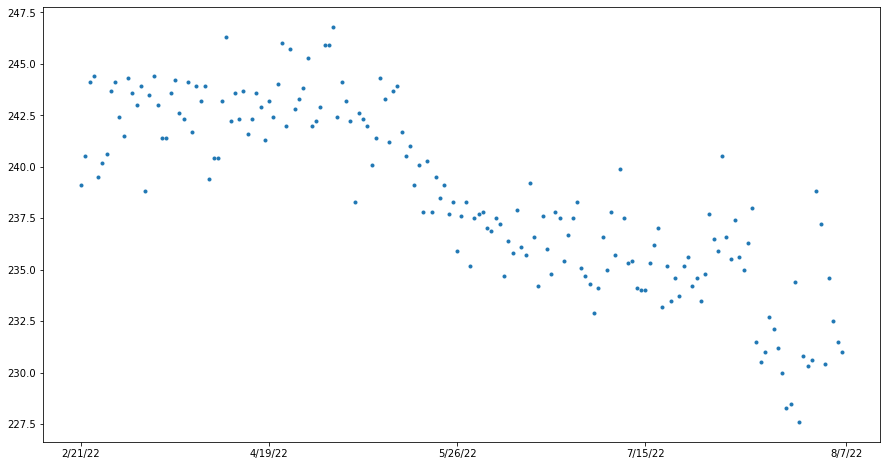

In [4]:
plt.figure(figsize=(15, 8))
plt.plot(range(0,df.shape[0]), df['weights'], linewidth=0, marker='.')
plt.xticks(ticks=dates_to_label.index,
          labels=dates_to_label['dates'],)

{'whiskers': [<matplotlib.lines.Line2D at 0x7faa6610d940>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa6610dd60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa65ede6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa66104a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa661043d0>],
 'means': []}

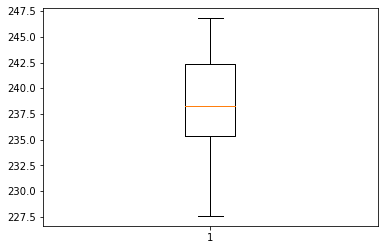

In [90]:
plt.boxplot(df['weights'])

In [92]:
df['weights'].describe()

count    179.000000
mean     238.608939
std        4.342982
min      227.600000
25%      235.350000
50%      238.300000
75%      242.400000
max      246.800000
Name: weights, dtype: float64

## Rolling average values for timecourse
**Pseudocode:** 
1. Start a window at position 0 of size n.
2. Compute the average within this window and store it
3. Move over one value
4. Repeat until we reach len(data)-n

In [39]:
rollingAverage = []
rollingStd = []
rawData = df['weights']
n = 5
for i in range(len(df['weights'])-n):
    windowStart = i
    windowEnd = i+n
    rollingAverage.append(np.mean(rawData[windowStart:windowEnd]))
    rollingStd.append(np.std(rawData[windowStart:windowEnd]))
#rollingAverage.extend(4*[rollingAverage[-1]])

## Turning it into a function

In [42]:
def rollingFun(data, windowSize, fun=np.mean):
    rollingAverage = []
    data = np.array(data)
    for i in range(len(data)-windowSize):
        windowStart = i
        windowEnd = i+windowSize
        rollingAverage.append(fun(data[windowStart:windowEnd]))
    return(rollingAverage)

Text(0.5, 1.0, 'The points deviate from the average by 1.613 pounds')

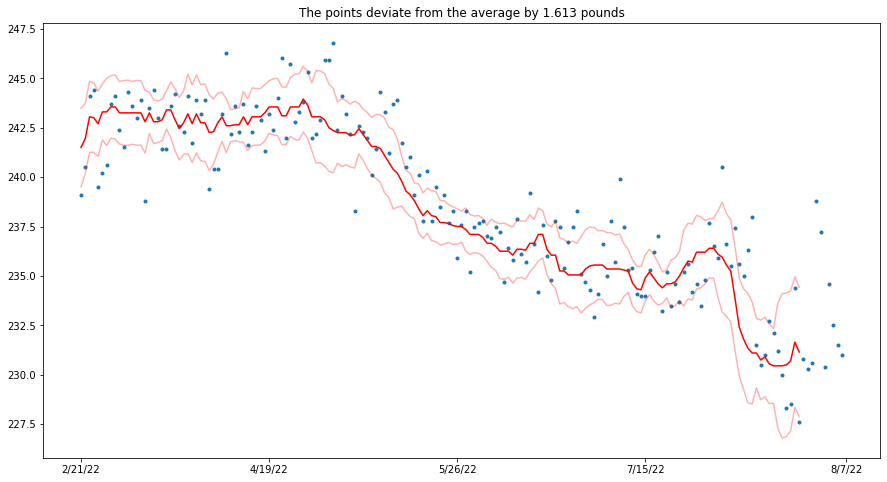

In [46]:
rollingAverage = rollingFun(df['weights'], 10, np.median)
rollingStd = rollingFun(df['weights'], 10, np.std)

plt.figure(figsize=(15, 8))
plt.plot(range(0,df.shape[0]), df['weights'], linewidth=0, marker='.')
plt.xticks(ticks=dates_to_label.index,
          labels=dates_to_label['dates'],)

plt.plot(rollingAverage, color='red')
plt.plot(np.array(rollingAverage) + np.array(rollingStd), color=[1,0,0], alpha=0.3)
plt.plot(np.array(rollingAverage) - np.array(rollingStd), color=[1,0,0], alpha=0.3)
plt.title(f"The points deviate from the average by {round(np.mean(rollingStd),3)} pounds")

In [36]:
np.mean(rollingFun(df['weights'], 20, np.std))

1.7676673501580733